In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join, Column, vstack
import re
from tqdm.notebook import tqdm
from scikitplot.metrics import plot_confusion_matrix
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


plt.rcParams['figure.figsize'] = (20, 10)

In [74]:
TEMP_TO_SPECTRAL = Table([
    Column(['O', 'B', 'A', 'F', 'G', 'K', 'M'], name='T'),
    Column([30000, 10000, 7500, 6000, 5200, 3700, 0.], name='MIN'),
    Column([np.inf, 30000, 10000, 7500, 6000, 5200, 3700], name='MAX')
])
SPECTRAL_NAMES = np.array(['UNKNOWN', 'O', 'B', 'A', 'F', 'G', 'K', 'M'])
LUMINOSITY_NAMES = np.flip(np.array(['I', 'II', 'III', 'IV', 'V']))
SED_LIB = Table.read('/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-SEDLIB-2013-11-14_MODIF.fits')

def classes_from_tu_seds(template_idx):
    seds = SED_LIB[template_idx]
    spectral = []
    for sed in tqdm(seds):
        match = np.logical_and(TEMP_TO_SPECTRAL['MIN'] < sed['TEFF'], sed['TEFF'] <= TEMP_TO_SPECTRAL['MAX'])
        assert match.sum() == 1
        spectral.append(TEMP_TO_SPECTRAL['T'][match][0])
    return np.array(spectral)

In [75]:
def categorical_idx(data, labels):
    """
    Returns the index of each categorical data entry in labels
    """
    sorter = np.argsort(labels)
    data_idx = sorter[np.searchsorted(labels, data, sorter=sorter)]
    return data_idx

In [89]:
IB_filters = [
    #('TU_FNU_VIS', 'euclid/VIS_MEAN'),
    #('TU_FNU_Y_NISP', 'euclid/Y_MEAN'),
    #('TU_FNU_H_NISP', 'euclid/H_MEAN'),
    #('TU_FNU_J_NISP', 'euclid/J_MEAN'),
    #('TU_FNU_G_LSST', 'lsst/g_MEAN'),
    #('TU_FNU_R_LSST', 'lsst/r_MEAN'),
    #('TU_FNU_I_LSST', 'lsst/i_MEAN'),
    #('TU_FNU_Z_LSST', 'lsst/z_MEAN'),
    ('TU_FNU_IB427_SUBARU', 'Subaru/IB427_MEAN'),
    #('TU_FNU_IB464_SUBARU', 'Subaru/IB464_MEAN'),
    #('TU_FNU_IB484_SUBARU', 'Subaru/IB484_MEAN'),
    #('TU_FNU_IB505_SUBARU', 'Subaru/IB505_MEAN'),
    ('TU_FNU_IB527_SUBARU', 'Subaru/IB527_MEAN'),
    #('TU_FNU_IB574_SUBARU', 'Subaru/IB574_MEAN'),
    #('TU_FNU_IB624_SUBARU', 'Subaru/IB624_MEAN'),
    #('TU_FNU_IB679_SUBARU', 'Subaru/IB679_MEAN'),
    ('TU_FNU_IB709_SUBARU', 'Subaru/IB709_MEAN'),
    #('TU_FNU_IB738_SUBARU', 'Subaru/IB738_MEAN'),
    #('TU_FNU_IB767_SUBARU', 'Subaru/IB767_MEAN'),
    ('TU_FNU_IB827_SUBARU', 'Subaru/IB827_MEAN'),
]

In [90]:
ref_table = Table.read('/home/aalvarez/Work/Data/StarSedsBackup/Reference.fits')
spectral = classes_from_tu_seds(ref_table['SED_TEMPLATE'])
spectral = categorical_idx(spectral, SPECTRAL_NAMES)
ref_table.add_column(Column(spectral, name='SP'))

In [91]:
true_photo = Table.read('/home/aalvarez/Work/Data/SC8/TU/Stars/Wide/Healpix/IB_2740.fits', hdu=1)
true_photo.rename_column('SOURCE_ID', 'OBJECT_ID')
spectral = classes_from_tu_seds(true_photo['SED_TEMPLATE'])
spectral = categorical_idx(spectral, SPECTRAL_NAMES)
true_photo.add_column(Column(spectral, name='SP'))

In [96]:
def plot_bands(catalog):
    ncols = 2
    nrows = len(IB_filters) // 2

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(20, 10))
    for (tu_f, mean_f), ax in zip(IB_filters, axes.ravel()):
        g0 = catalog[tu_f] > 0
        
        ax.set_title(mean_f)
        ratio = (catalog[mean_f] / (catalog[tu_f]*1e6))
              
        good = catalog['FLAGS_1'] == 0
        mean_all = np.mean(ratio)
        std_all = np.std(ratio)
        mean_good = np.mean(ratio[good])
        std_good = np.std(ratio[good])
                
        ax.scatter(catalog[tu_f][g0], ratio[g0], marker='1', alpha=0.4,
                   label=f'All {len(catalog)} ($\mu$ {mean_all:.2f}, $\sigma$ {std_all:.2f})')
        ax.scatter(catalog[tu_f][good & g0], ratio[good & g0], marker='.',
                   label=f'Not flagged {good.sum()} ($\mu$ {mean_good:.2f}, $\sigma$ {std_good:.2f})')
        ax.axhline(1, linestyle='--', color='red')
        
        ax.set_xlabel('uJy')
        ax.set_ylabel('$\\dfrac{F_\mu}{F}$')
        ax.set_xscale('log')
        ax.set_ylim(-0.5, 2.5)

        ax.legend()
    plt.tight_layout()

In [97]:
nnpz = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/NnpzStarSed/output_file.fits')

In [98]:
matched = join(true_photo, nnpz, 'OBJECT_ID')

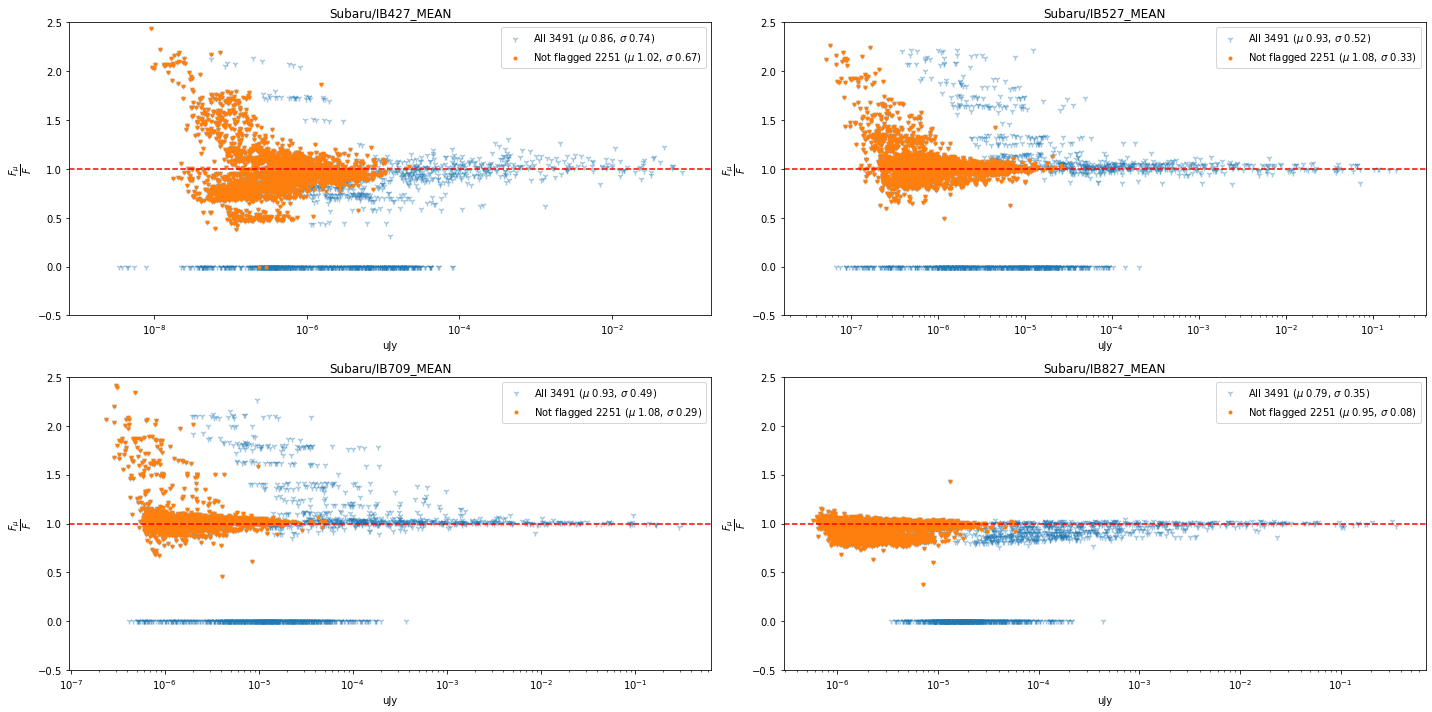

In [99]:
plot_bands(matched)

In [85]:
def confusion_matrix(combined, items=slice(None)):
    majority = []
    nneighbors = combined['NEIGHBOR_IDS'].shape[1]
    for row in tqdm(combined[items]):
        mask = np.in1d(ref_table['ID'], row['NEIGHBOR_IDS'])
        votes = ref_table['SP'][mask]
        counts = np.bincount(votes)
        best = np.argmax(counts)
        if counts[best] > 2:
            majority.append(best)
        else:
            majority.append(0)
    plot_confusion_matrix(SPECTRAL_NAMES[combined['SP'][items]], SPECTRAL_NAMES[majority], labels=SPECTRAL_NAMES, normalize=False)

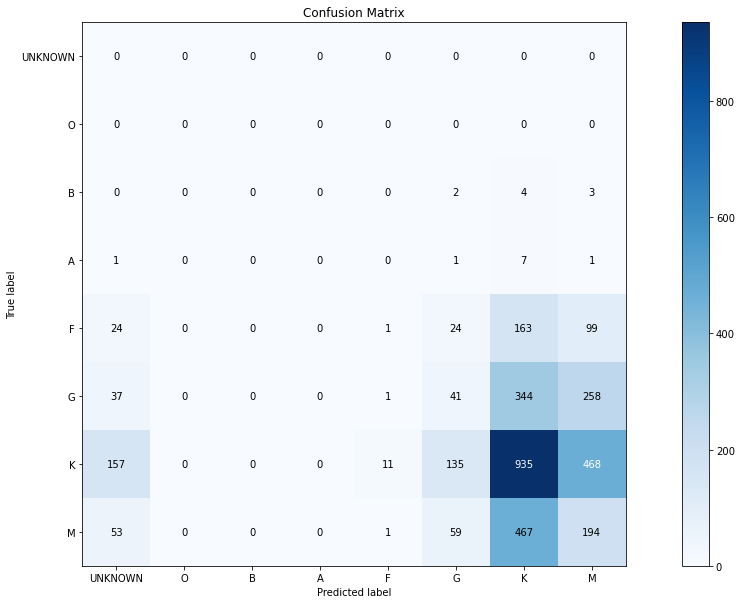

In [87]:
confusion_matrix(matched)

In [88]:
len(nnpz)

5000